# Selecting the number of clusters with silhouette analysis


Silhouette analysis can be used to study the separation distance between the
resulting clusters. The silhouette plot displays a measure of how close each
point in one cluster is to points in the neighboring clusters and thus provides
a way to assess parameters like number of clusters visually. This measure has a
range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate
that the sample is far away from the neighboring clusters. A value of 0
indicates that the sample is on or very close to the decision boundary between
two neighboring clusters and negative values indicate that those samples might
have been assigned to the wrong cluster.

Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

In [1]:
%matplotlib inline

In [2]:
from Bio import Entrez
import nltk
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
stemmer = SnowballStemmer("english")

In [4]:
filename = 'pmids_test_set_unlabeled.txt'

with open('data/' + filename, 'r') as f:
    lines = f.readlines()

pmids = [line.rsplit()[0] for line in lines]

Entrez.email = 'spawar3@uncc.edu'

handle = Entrez.efetch(db="pubmed", id=','.join(pmids), rettype="xml", retmode="text")
records = Entrez.read(handle)

abstracts = []

for article in records['PubmedArticle']:
    if 'Abstract' in article['MedlineCitation']['Article'].keys():
        abstract = article['MedlineCitation']['Article']['Abstract']
        abstract_text = abstract['AbstractText'][0]
        abstracts.append(abstract_text)
    else:
        abstracts.append(
            article['MedlineCitation']['Article']['ArticleTitle'])

In [5]:
stopwords = nltk.corpus.stopwords.words('english')

stemmed_stopwords = [
    stemmer.stem(w) for w in stopwords] + [
    "'d",
    'could',
    'might',
    'must',
    "n't",
    'need',
    'r',
    'sha',
    'v',
    'wo',
    'would']

In [6]:
def tokenize(text, stem=True):
    tokens = [word for sent in nltk.sent_tokenize(
        text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)

    if stem:
        tokens = [stemmer.stem(t) for t in filtered_tokens]
        return tokens
    else:
        return filtered_tokens

In [7]:
n_components = 100

tfidf_vectorizer = TfidfVectorizer(stop_words=stemmed_stopwords, use_idf=True, tokenizer=tokenize, ngram_range=(1, 3))
tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts)

svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(tfidf_matrix)

# Using TSNE to reduce dimensionality to 2 for visualization
X = TSNE(n_components=2).fit_transform(X)

For n_clusters = 2 The average silhouette_score is : 0.39001775
For n_clusters = 3 The average silhouette_score is : 0.44681218
For n_clusters = 4 The average silhouette_score is : 0.40590146
For n_clusters = 5 The average silhouette_score is : 0.390007
For n_clusters = 6 The average silhouette_score is : 0.43401763
For n_clusters = 7 The average silhouette_score is : 0.44184494
For n_clusters = 8 The average silhouette_score is : 0.4211407


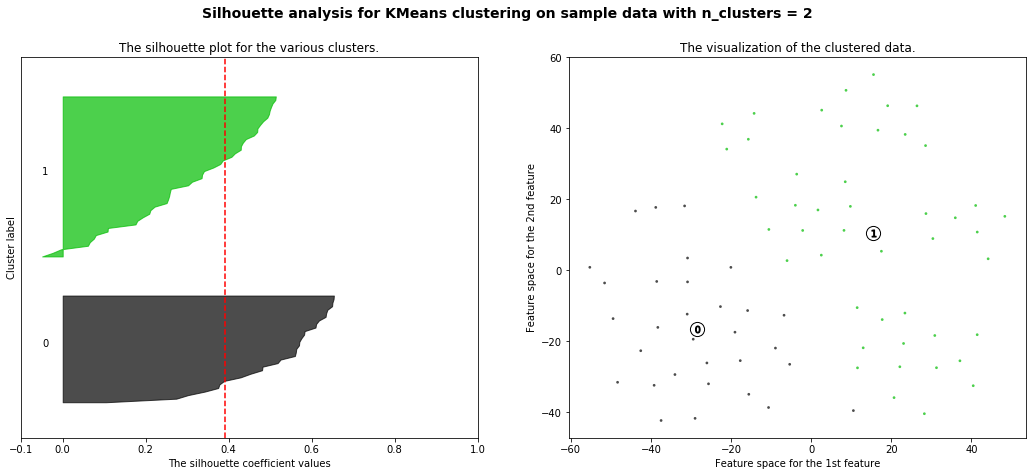

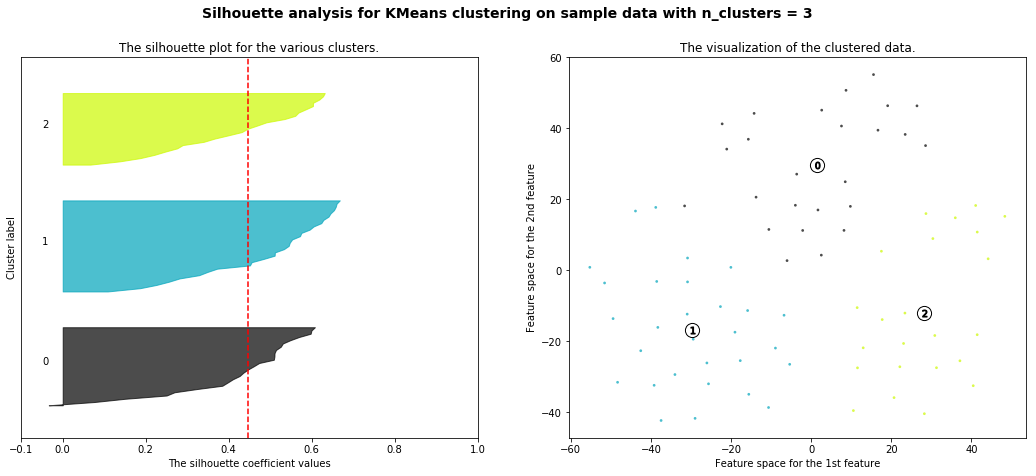

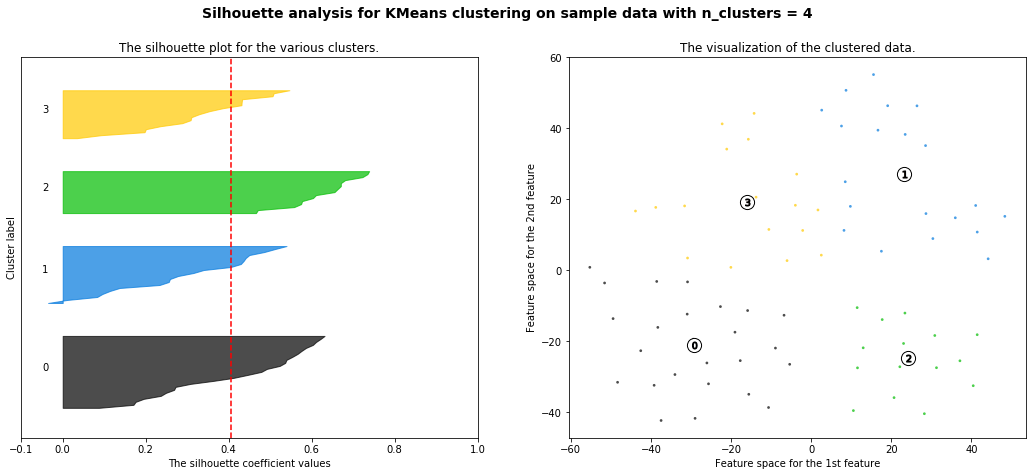

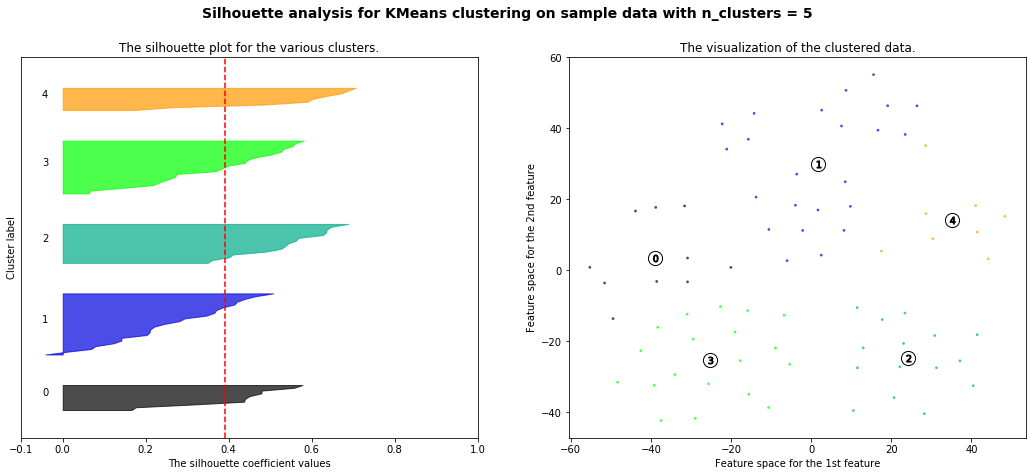

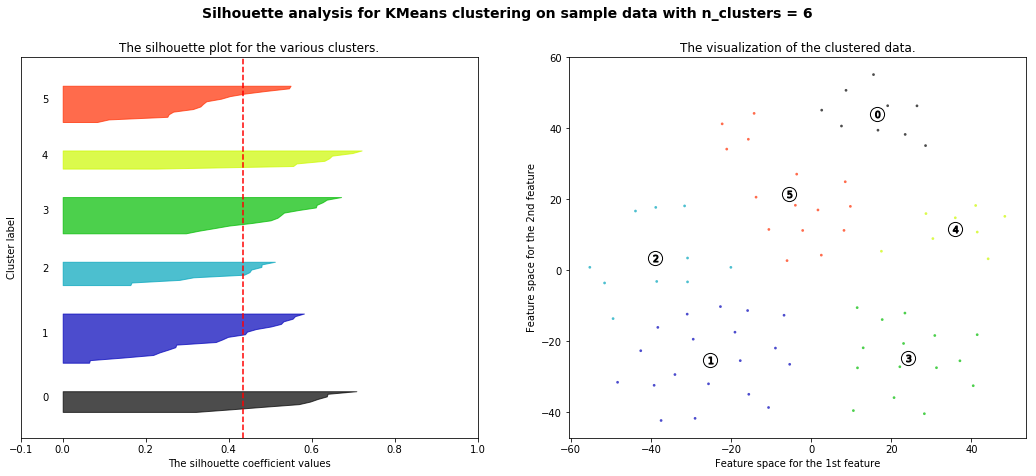

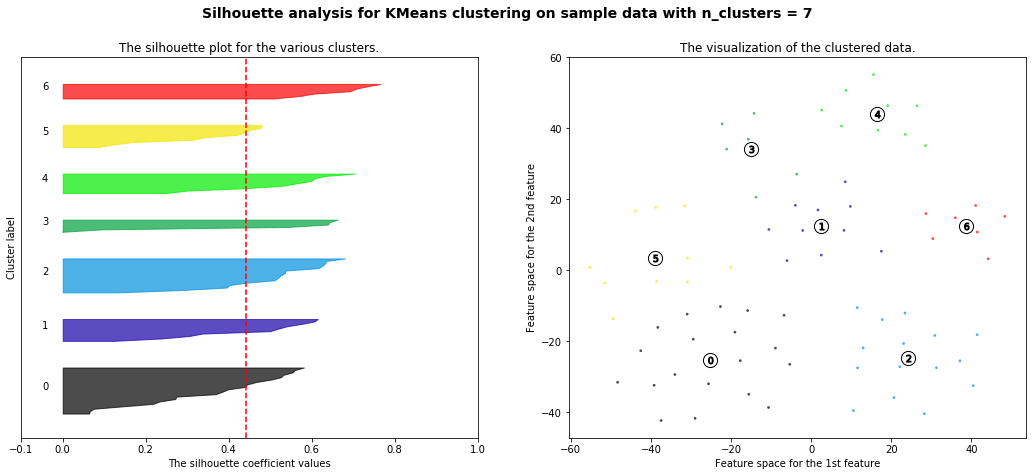

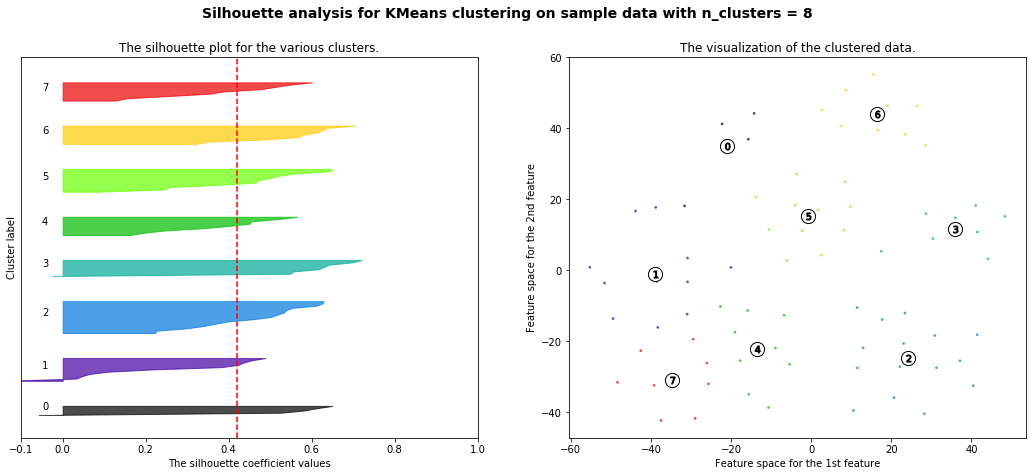

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but we only need to
    # see if there are any negative values
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The silhouette plot shows that the ``n_clusters`` value of 2, 3, 4, 5 and 8 are a bad pick due to the presence of clusters with samples having negative silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 6 and 7.

When the value of ``n_clusters`` is 6 and 7, the cluster sizes are fairly homogeneous with all clusters having above average and positive silhouette scores. Hence, we can conclude that 6 and 7 are the optimum values for the number of clusters on this data. Further analysis can be performed using output cluster compositions to see what value of ``n_clusters`` produces distinct and well defined clusters.